In [1]:

import pdb,sys,os
import anndata
import scanpy as sc
sc.settings.verbosity = 0
import argparse
import copy
import numpy as np
import scipy

import timeit
import warnings
warnings.filterwarnings('ignore')

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt


/mnt/data/jingtao2/anaconda3/envs/semi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import scSemiProfiler
from scSemiProfiler import initsetup,get_eg_representatives,scprocess,scinfer,activeselect
from scSemiProfiler.utils import *

scVI ready


# Example
We provide an example dataset containing 12 samples from COVID-19 patients with 6 different severity levels. We will go through the process of using scSemiProfiler to semi-profile this example cohort. Then we will evaluate the semi-profiling performance by comparing the downstream anlaysis results using the semi-profiled cohort and the real-profiled cohort. We will show that even with only 2 representatives, we can accurately reproduce single-cell level downstream analysis results. Particularly, samples of different COVID-19 severity level can also be accurately inferred.

## Step 1 Initial Setup 
The user provided bulk data is preprocessed, dimensionality reduced, and clustered. 
The sample closest to the cluster centroids are selected as initial representatives.\
*Estimated Time: Less than 1 minute*

In [3]:
name = 'runexample'
bulk = 'example_data/bulkdata.h5ad'
normed = 'yes'
geneselection = 'no'
batch = 2

In [6]:
initsetup.initsetup(name, bulk,normed,geneselection,batch)

Start initial setup
Initial setup finished. Selected 2 representatives:
BGCV09_CV0279
MH9143426


In [63]:
_ = estimate_cost(12,2)


Estimated semi-profiling cost: $11320.0
Estimated cost if conducting real single-cell profiling: $18000.0
Percentage saved: 37.1%


## Step 1.5 Acquiring Single-cell Data for Representatives
The user will sequence the representatives to obtain their actual single-cell data. In our example, we offer a function that allows for the extraction of representatives' single-cell data from a pre-prepared dataset.\
*Estimated Time: Less than 1 minute*

In [7]:
get_eg_representatives.get_eg_representatives(name)

Obtained single-cell data for representatives.


## Step 2 Single-cell Processing & Feature Augmentation
In this step, we preprocess the representatives' single-cell data and apply various feature augmentations.These enhancements include the addition of gene set scores, aggregation of neighbor cell information, and calculation of gene importance weights.\
*Estimated Time: 2 minutes for each sample with 7000 cells*

In [4]:
scprocess.scprocess(name=name,singlecell=name+'/representative_sc.h5ad',normed='yes',cellfilter='no',threshold=1e-3,geneset='yes',weight='yes',k=15)

Processing representative single-cell data
Removing background noise
Computing geneset scores
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
Augmenting and saving single-cell data.
Finished processing representative single-cell data


## Step 3 Single-cell Inference
In this step, we employ a VAE-GAN-based deep generative model to infer the single-cell data for each target (non-representative) sample.\
The model training is divided into three distinct stages:

1. **Pretrain 1**: The model is trained to reconstruct the representatives' single-cell data.

2. **Pretrain 2**: The model continues its reconstruction training in full batch mode, now incorporating an additional "representative bulk loss" term in the loss function. This term ensures that the reconstructed cells' average expression is similar to pseudobulk.

3. **Inference**: The bulk data difference between the representative and target sample is integrated into the generator's reconstruction process through a 'target bulk loss'. This guides the generator to accurately infer the target sample's cells.


*Estimated Time for Samples with Approximately 7000 Cells*:
   - Pretrain 1: 15 minutes per sample
   - Pretrain 2: 5 minutes per sample
   - Inference: 30 minutes per sample

In [ ]:
representatives = name + '/status/init_representatives.txt'
cluster = name + '/status/init_cluster_labels.txt'

bulktype = 'pseudobulk'
scinfer(name, representatives,cluster,targetid,bulktype)

Start single-cell inference in cohort mode
pretrain 1: representative reconstruction
load existing pretrain 1 reconstruction model for BGCV09_CV0279


I0000 00:00:1701842245.355163 2958311 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


INFO     Generating sequential column names                                                                        
load existing pretrain 1 reconstruction model for MH9143426
INFO     Generating sequential column names                                                                        
pretrain2: reconstruction with representative bulk loss
load existing model
load existing pretrain 2 model for BGCV09_CV0279
INFO     Generating sequential column names                                                                        
load existing model
load existing pretrain 2 model for MH9143426
INFO     Generating sequential column names                                                                        
inference
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 400/400: 100%|█| 400/400 [08:09<00:00,  1.22s/it, v_num=1, train_loss_

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█| 400/400 [08:09<00:00,  1.22s/it, v_num=1, train_loss_


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 400/400: 100%|█| 400/400 [08:07<00:00,  1.21s/it, v_num=1, train_loss_

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█| 400/400 [08:07<00:00,  1.22s/it, v_num=1, train_loss_


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 200/200: 100%|█| 200/200 [04:04<00:00,  1.20s/it, v_num=1, train_loss_

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|█| 200/200 [04:04<00:00,  1.22s/it, v_num=1, train_loss_


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 200/200: 100%|█| 200/200 [04:01<00:00,  1.19s/it, v_num=1, train_loss_

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|█| 200/200 [04:01<00:00,  1.21s/it, v_num=1, train_loss_


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 400/400: 100%|█| 400/400 [07:56<00:00,  1.19s/it, v_num=1, train_loss_

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█| 400/400 [07:56<00:00,  1.19s/it, v_num=1, train_loss_
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 342/400:  85%|▊| 341/400 [02:24<00:25,  2.34it/s, v_num=1, train_loss_

## Performance evaluation

After the inference is finished for the cohort, we first perform some basic visualization to see if the model training was successful.

In [4]:
repres = []
f=open(name + '/status/init_representatives.txt','r')
lines = f.readlines()
f.close()
for l in lines:
    repres.append(int(l.strip()))

cl = []
f=open(name + '/status/init_cluster_labels.txt','r')
lines = f.readlines()
f.close()
for l in lines:
    cl.append(int(l.strip()))

### Reconstruction
Firstly, successful pretrain should generate near perfect reconstruction. We compare the representative's reconstructed cells with the original ones.

CUDA backend failed to initialize: Found CUDA version 11030, but JAX was built against version 11080, which is newer. The copy of CUDA that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


INFO     Generating sequential column names                                                                        


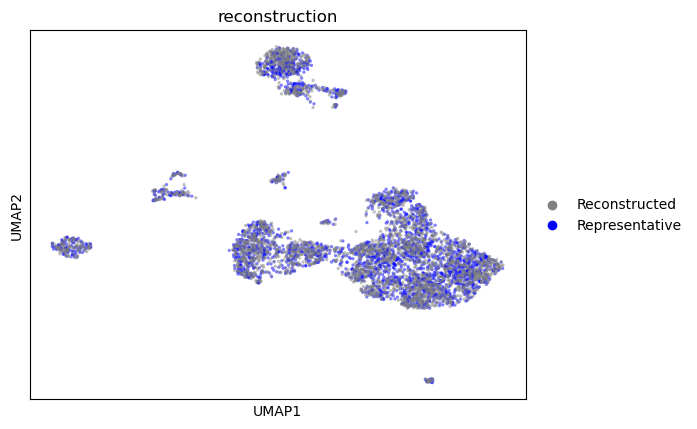

In [5]:
visualize_recon(name, 6)

The overlap indicates the reconstructed cells and representative cells are similar.

### Target sample inference
Then, for any target sample, successful inference should generate target cells closer to the target ground truth than to the representative cells.

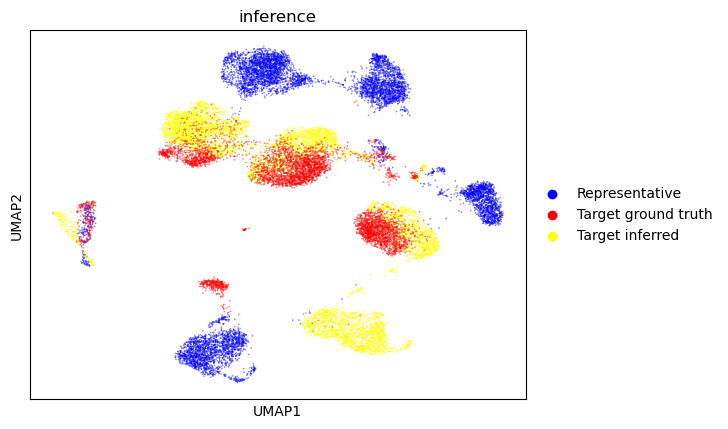

In [6]:
visualize_inferred(name, 0, repres, cl)

The overlap between the target inferred cells and target ground truth indicates good inference performance.

### Check training loss curve
visualizing the loss curve during training:

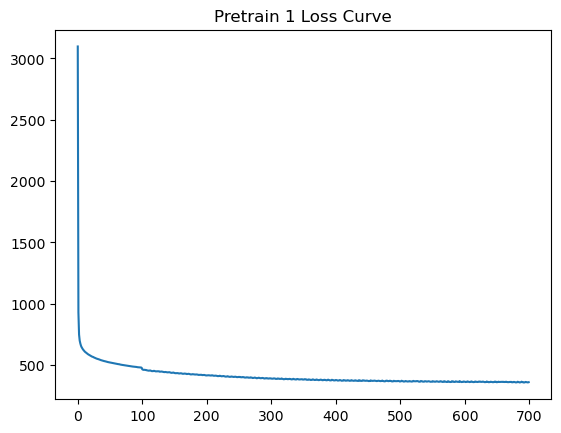

In [7]:
# PRETRAIN 1
# select a representative and check pretrain 1 loss curve
loss_curve(name, reprepid='BGCV09_CV0279',tgtpid=None,stage=1) # or loss_curve(name, sids, reprepid=6,tgtpid=None,stage=1)

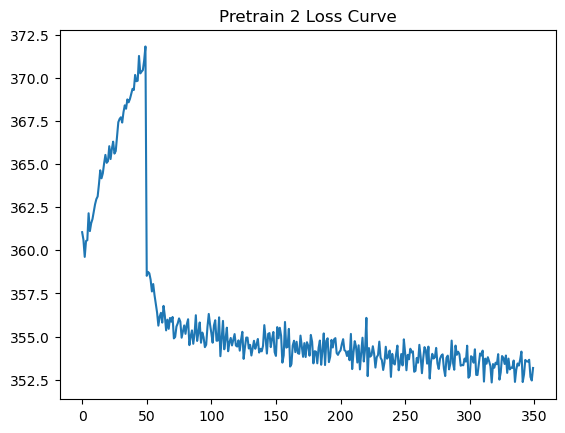

In [8]:
# PRETRAIN 2
loss_curve(name, reprepid='BGCV09_CV0279',tgtpid=None,stage=2) 

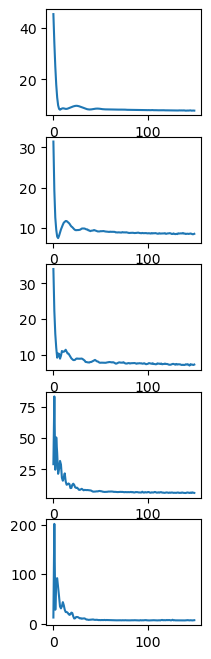

In [9]:
# INFERENCE
# target bulk loss during 5 ministages for inference
loss_curve(name, reprepid=6,tgtpid=1,stage=3)

## Comprehensive evaluation using more downstream tasks
We can assemble the representatives' single-cell data and all inferred single-cell data into a semi-profiled cohort and use it to do all kinds of single-cell analysis. We compare the analysis results generated using the real-profiled cohort and semi-profiled cohort to evaluate the performance of semi-profiling.

### Assemble semi-profiled cohort
(training an MLP to annotate the cell types takes around 5 minutes)

In [13]:
representatives = repres
cluster_labels = cl
semisdata = assemble_cohort(name,
                representatives,
                cluster_labels,
                celltype_key = 'celltypes',
                sample_info_keys = ['states_collection_sum'])

Start assembling semi-profiled cohort.
Training cell type annotator.
Finished. Cost 189.30423514000722 seconds.
Generating semi-profiled cohort data.
Finished assembling semi-profiled cohort. Output as semidata.h5ad


### Read the real-profiled single-cell data to compare to

In [14]:
gtdata = anndata.read_h5ad('example_data/scdata.h5ad')

### Compare the UMAP visualization
(The dimensionality reduction and neighbor graph calculation could be slow, taking around 5 minutes)

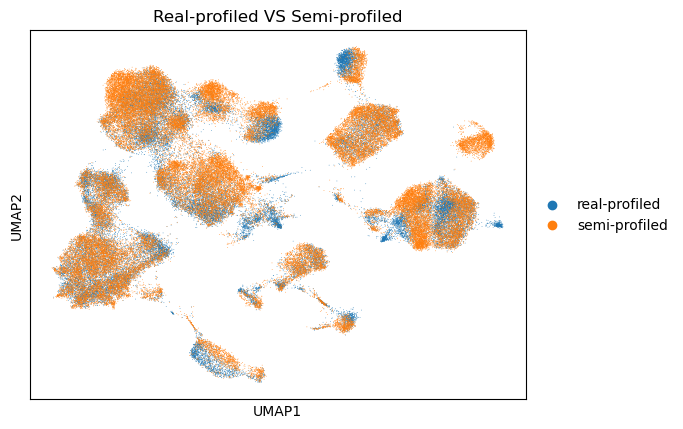

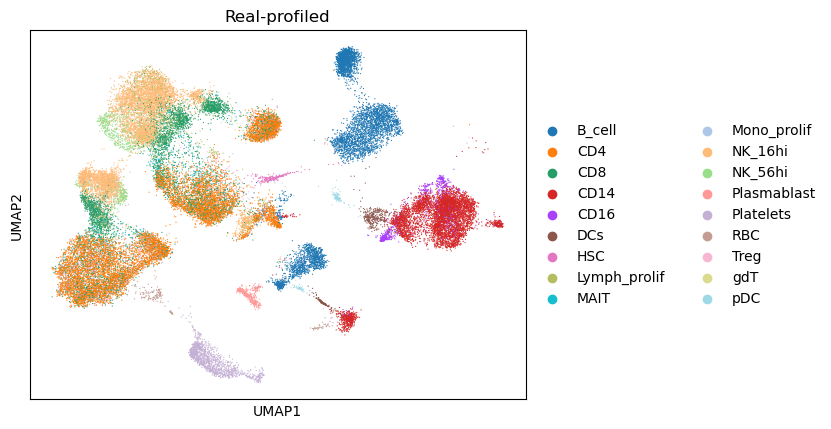

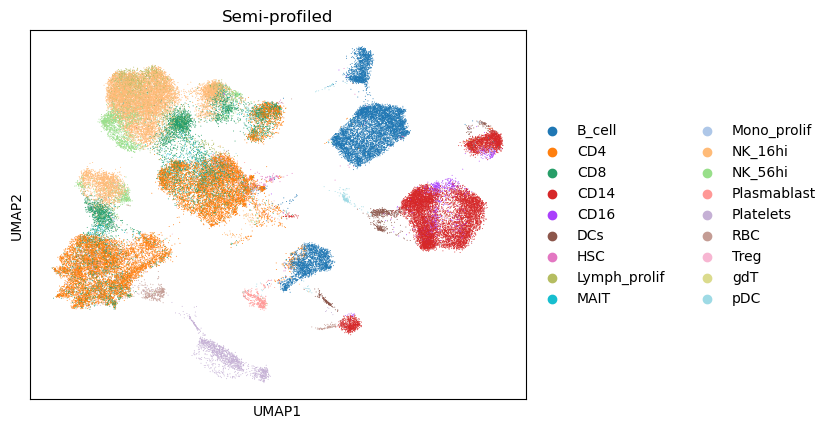

In [18]:
st= timeit.default_timer()
combined_data,gtdata,semidata = compare_umaps(
            semidata = semisdata,
            name = name,
            representatives = name + '/status/init_representatives.txt',
            cluster_labels = name + '/status/init_cluster_labels.txt',
            celltype_key = 'celltypes'
            )

### Compare cell type composition

In [24]:
totaltypes = np.array(semisdata.obs['celltypes'].cat.categories)
gtprop = celltype_proportion(gtdata,totaltypes)
semiprop = celltype_proportion(semisdata,totaltypes)
print('Pearson Correlation between the two versions of cell type proportions:')
print(scipy.stats.pearsonr(gtprop,semiprop))

Pearson Correlation between the two versions of cell type proportions:
PearsonRResult(statistic=0.9842350182723907, pvalue=1.8260656886315043e-13)


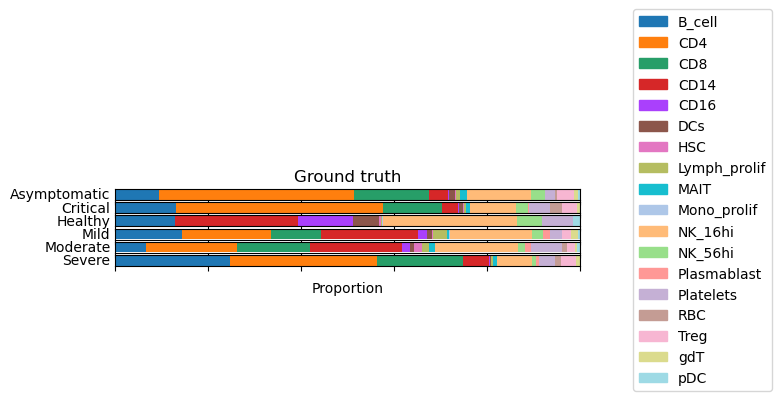

In [27]:
groupby = 'states_collection_sum'
composition_by_group(
    adata = gtdata,
    groupby = groupby,
    title = 'Ground truth'
    )


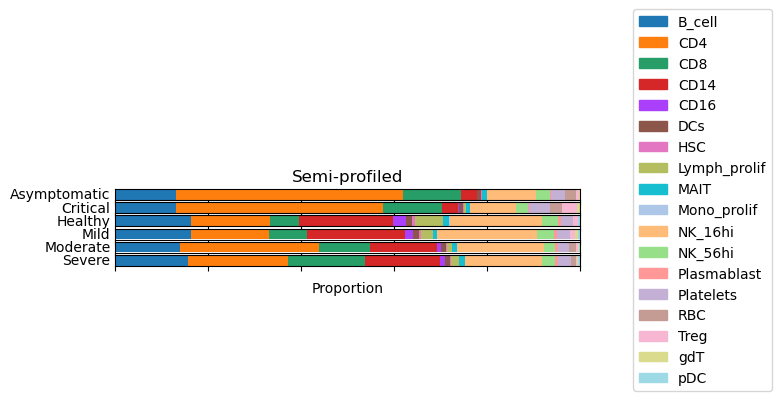

In [28]:
groupby = 'states_collection_sum'
composition_by_group(
    adata = semisdata,
    groupby = groupby,
    title = 'Semi-profiled'
    )

### Compare gene set activation pattern
We use the interferon pathway used in the COVID-19 study as an example.

In [29]:
#https://www.gsea-msigdb.org/gsea/msigdb/cards/GO_RESPONSE_TO_TYPE_I_INTERFERON
IFN_genes = ["ABCE1", "ADAR", "BST2", "CACTIN", "CDC37", "CNOT7", "DCST1", "EGR1", "FADD", "GBP2", 	"HLA-A", 	"HLA-B", 	"HLA-C", 	"HLA-E", 	"HLA-F", 	"HLA-G", 	"HLA-H", 	"HSP90AB1", 	"IFI27", 	"IFI35", 	"IFI6", 	"IFIT1", 	"IFIT2", 	"IFIT3", 	"IFITM1", 	"IFITM2", 	"IFITM3", 	"IFNA1", 	"IFNA10", 	"IFNA13", 	"IFNA14", 	"IFNA16", 	"IFNA17", 	"IFNA2", 	"IFNA21", 	"IFNA4", 	"IFNA5", 	"IFNA6", 	"IFNA7", 	"IFNA8", 	"IFNAR1", 	"IFNAR2", 	"IFNB1", 	"IKBKE", 	"IP6K2", 	"IRAK1", 	"IRF1", 	"IRF2", 	"IRF3", 	"IRF4", 	"IRF5", 	"IRF6", 	"IRF7", 	"IRF8", 	"IRF9", 	"ISG15", 	"ISG20", 	"JAK1", 	"LSM14A", 	"MAVS", 	"METTL3", 	"MIR21", 	"MMP12", 	"MUL1", 	"MX1", 	"MX2", 	"MYD88", 	"NLRC5", 	"OAS1", 	"OAS2", 	"OAS3", 	"OASL", 	"PSMB8", 	"PTPN1", 	"PTPN11", 	"PTPN2", 	"PTPN6", 	"RNASEL", 	"RSAD2", 	"SAMHD1", 	"SETD2", 	"SHFL", 	"SHMT2", 	"SP100", 	"STAT1", 	"STAT2", 	"TBK1", 	"TREX1", 	"TRIM56", 	"TRIM6", 	"TTLL12", 	"TYK2", 	"UBE2K", 	"USP18", 	"WNT5A", "XAF1", "YTHDF2", "YTHDF3", "ZBP1"]

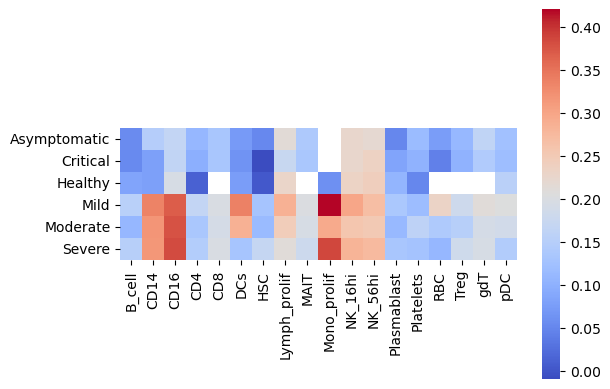

In [34]:
gtmtx = geneset_pattern(gtdata,IFN_genes,'states_collection_sum','celltypes')

In [36]:
if semisdata.X.max() > 20:
    sc.pp.log1p(semisdata)

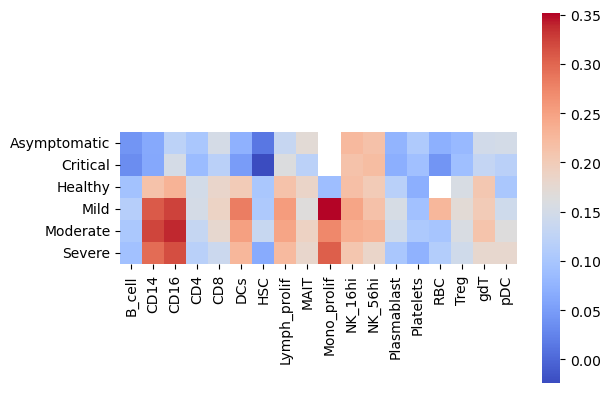

In [37]:
semismtx = geneset_pattern(semisdata,IFN_genes,'states_collection_sum','celltypes')

In [53]:
print('Correlation between the two heatmaps:')
scipy.stats.pearsonr(np.nan_to_num(gtmtx.flatten(),0),np.nan_to_num(semismtx.flatten(),0))

Correlation between the two heatmaps:


PearsonRResult(statistic=0.824605073506332, pvalue=5.559004210779983e-28)

Based on only 2 representatives, the semi-profiled data reproduces the pattern for all COVID-19 severity levels accurately.

### Compare top cell type signature genes

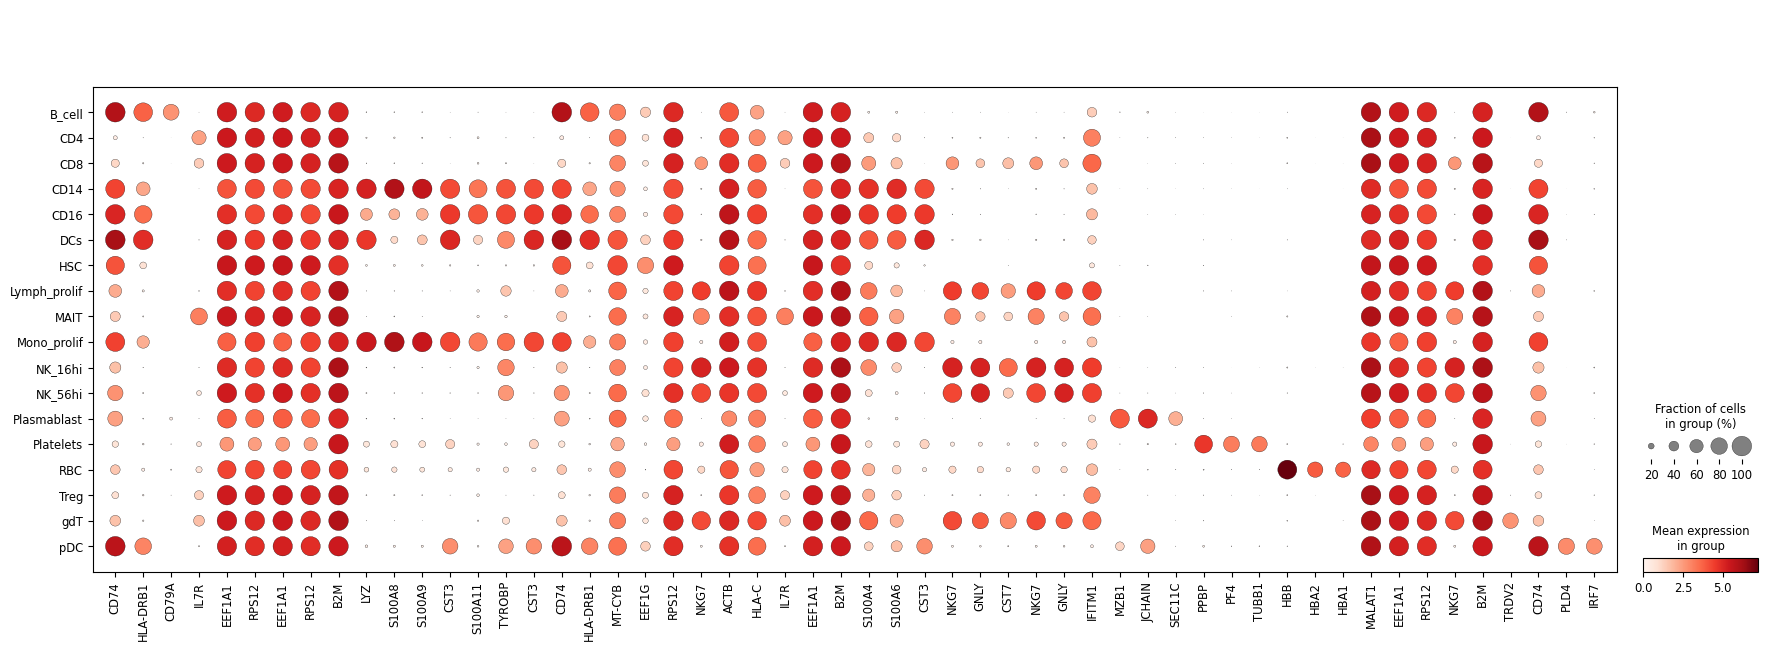

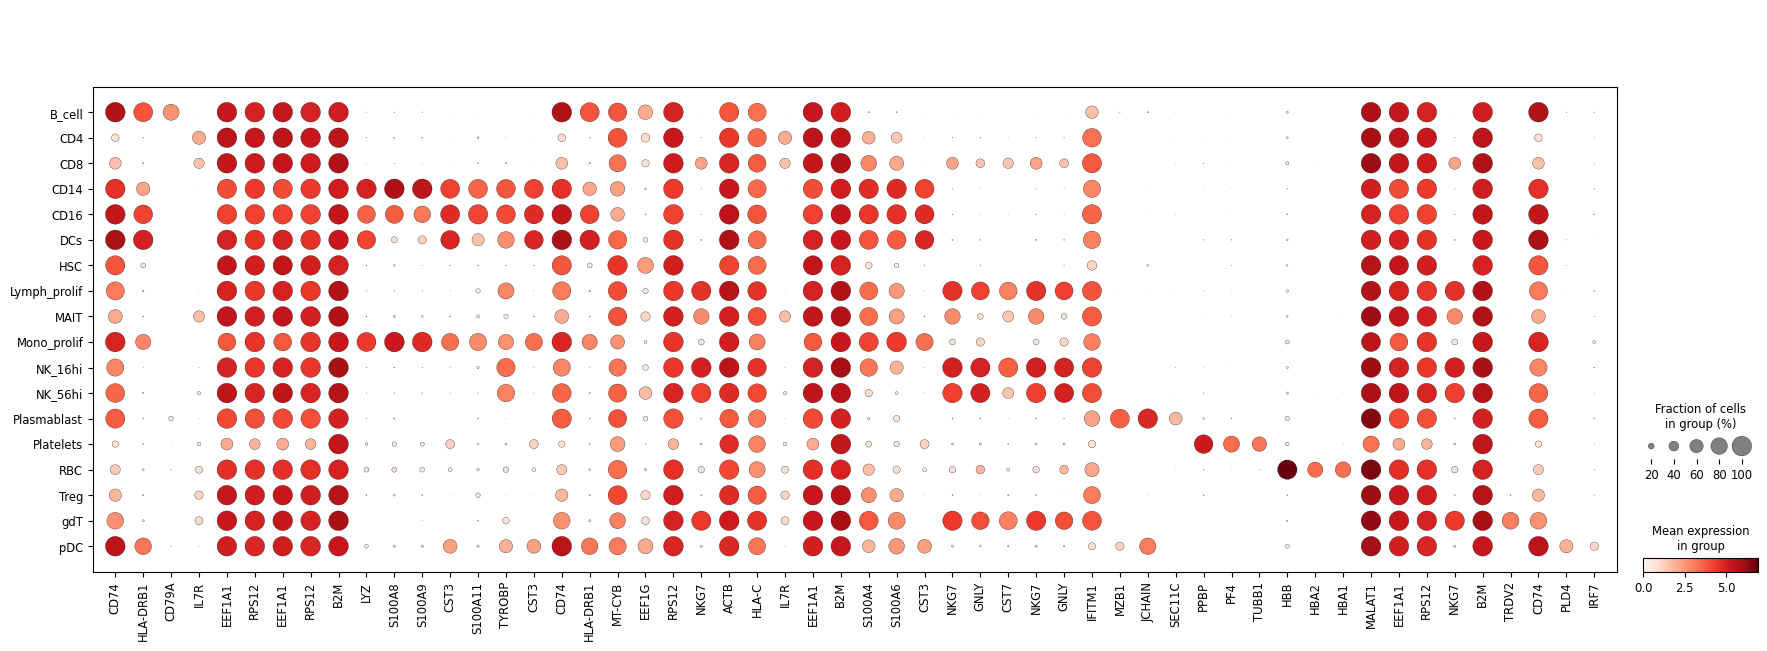

Expression fraction (size) similarity between real and semi-profiled:
PearsonRResult(statistic=0.9825868563126193, pvalue=0.0)
Expression intensity (color) similarity between real and semi-profiled
PearsonRResult(statistic=0.9886825546484544, pvalue=0.0)


In [38]:
celltype_signature_comparison(gtdata=gtdata,semisdata=semisdata,celltype_key='celltypes')

### Use RRHO plot to compare markers


In [40]:
# choose any cell type
print(totaltypes)
selected_celltype = 'CD4'

['B_cell' 'CD4' 'CD8' 'CD14' 'CD16' 'DCs' 'HSC' 'Lymph_prolif' 'MAIT'
 'Mono_prolif' 'NK_16hi' 'NK_56hi' 'Plasmablast' 'Platelets' 'RBC' 'Treg'
 'gdT' 'pDC']


Plotting RRHO for comparing CD4 markers.


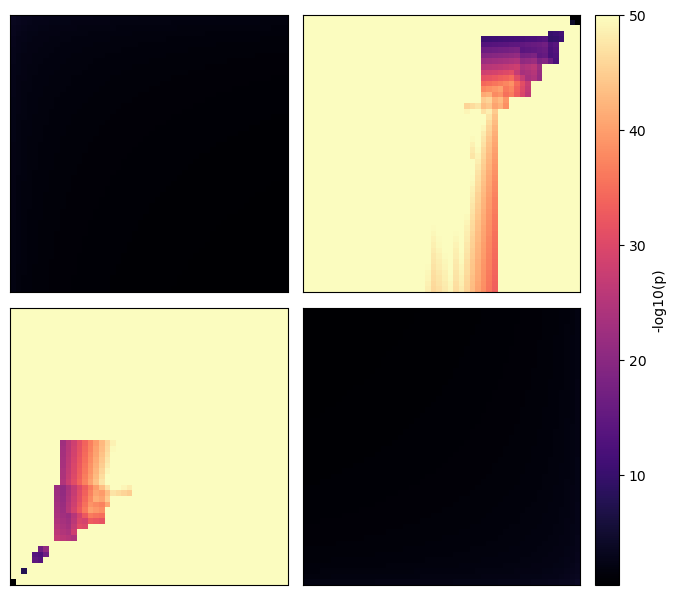

In [42]:
rrho(gtdata=gtdata,semisdata=semisdata,celltype_key='celltypes',celltype=selected_celltype)

### Compare GO enrichment analysis similarity

p-value of hypergeometric test for overlapping DEGs: 2.503329243550031e-165
Significance correlation: PearsonRResult(statistic=0.9965959843736519, pvalue=2.81960927017642e-13)


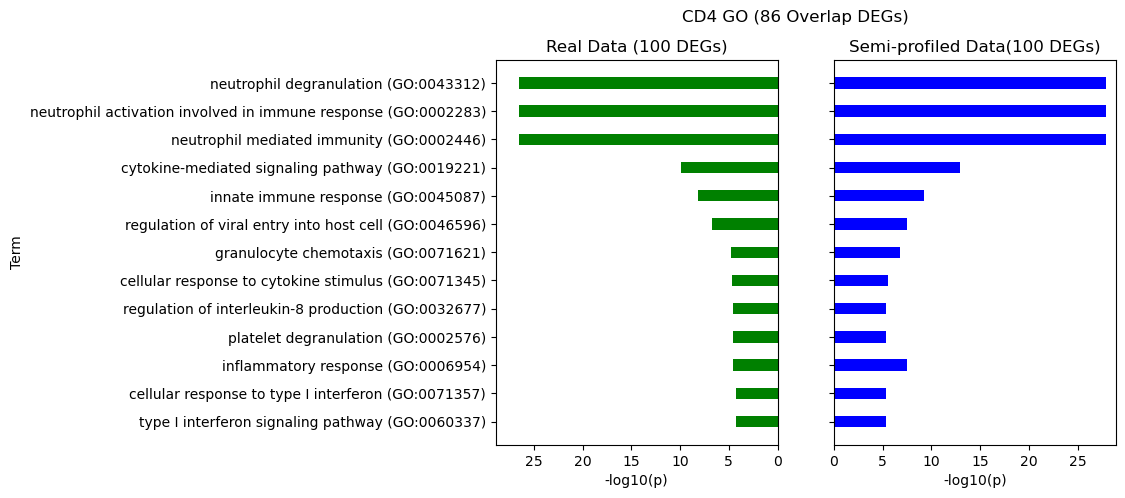

In [46]:
selected_celltype = 'CD4'
enrichment_comparison(name, gtdata, semisdata, celltype_key = 'celltypes', selectedtype = selected_celltype)

### Compare partition-based graph abstraction (PAGA) graph similarity

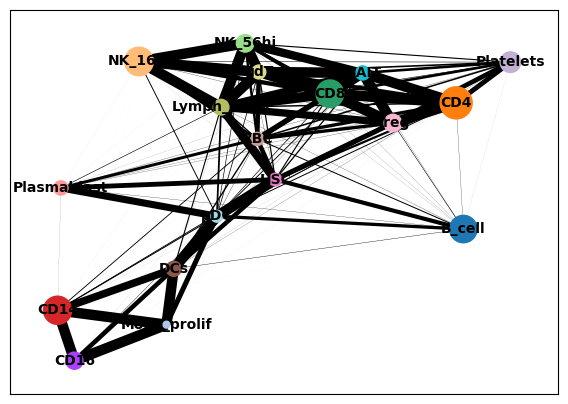

In [48]:
# GROUND TRUTH
threshold = 0
sc.tl.pca(gtdata,n_comps=100)
sc.pp.neighbors(gtdata,use_rep='X_pca',n_neighbors=50)
sc.tl.paga(gtdata, groups = 'celltypes')
sc.pl.paga(gtdata, plot=True,threshold=threshold)

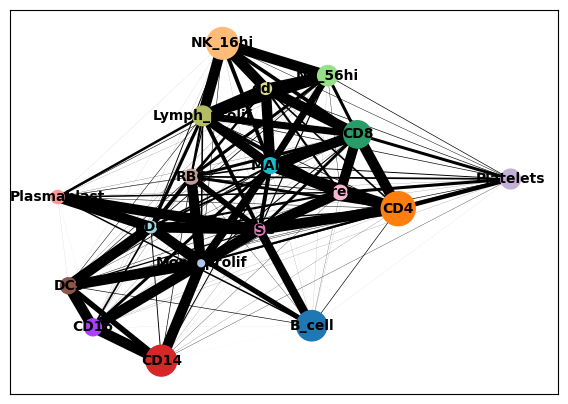

In [49]:
# SEMI-PROFILED
threshold = 0
sc.tl.pca(semisdata,n_comps=100)
sc.pp.neighbors(semisdata,use_rep='X_pca',n_neighbors=50)
sc.tl.paga(semisdata, groups = 'celltypes')
sc.pl.paga(semisdata, plot=True,threshold=threshold)

In [50]:
gtpaga = np.array(gtdata.uns['paga']['connectivities'].todense())
semipaga = np.array(semisdata.uns['paga']['connectivities'].todense())
gtpaga = gtpaga.reshape((-1))
semipaga= semipaga.reshape((-1))
print('Correlation between the two adjacency matrices:')
scipy.stats.pearsonr(gtpaga,semipaga)

Correlation between the two adjacency matrices:


PearsonRResult(statistic=0.847876215624918, pvalue=9.702626948663493e-91)

### Using CellChat to perform cell-cell interaction analysis
If you would like to perform cell-cell interaction analysis using CellChat, we recommend creating another conda environment according to the instructions below: \
Create environment: 
```
conda create -n r_analysis r-essentials r-base
```
Activate it: 
```
conda activate r_analysis
```
Start an interactive R session:
```
R
```
Install necessary packages:

1
```
install.packages('devtools')
```

2
```
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
 
BiocManager::install("Biobase")
```

3 
```
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
 
BiocManager::install("ComplexHeatmap")
```

4
```
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
 
BiocManager::install("BiocNeighbors")
```

5
```
devtools::install_github("sqjin/CellChat")
```

Then install this R environment as a Jupyter Notebook kernel:

```
install.packages('IRkernel')
IRkernel::installspec(user = TRUE)

```

This finishes configuring the environment needed. You should be able to select the 'R' kernel in Jupyter Notebook. We will export some single-cell data for cell-cell interaction analysis.

### Export single-cell data for analysis
We export real and semi-profiled cells from moderate COVID-19 patients.

In [82]:
condition_real = gtdata[gtdata.obs['states_collection_sum'] == 'Moderate']
condition_semi = semisdata[semidata.obs['states_collection_sum'] == 'Moderate']
condition_real.write(name + '/moderate_real.h5ad')
condition_semi.write(name + '/moderate_semi.h5ad')

Then please open our notebook "cellchat_eg.ipynb" to proceed with the analysis. 

## End of comprehensive semi-profiling performance evaluation
Based on only two representative samples, the semi-profiled 12-sample cohort has very similar downstream analysis results as the real-profiled cohort, which contains heterogeneous samples from 6 different COVID-19 severity levels.

## Optional: New Representative Selection and Run the Next Round
You have the option to employ active learning for the selection of additional representatives. This approach can result in some target samples having more similar representatives, thereby enhancing the accuracy of the inference process.

## Round 2 semi-profiling

### select a new batch of representatives using active learning:

In [8]:
representatives = 'testrun/status/init_representatives.txt'
cluster = 'testrun/status/init_cluster_labels.txt'
targetid = None
bulktype = 'pseudobulk'

In [13]:
activeselect.activeselection(name, representatives,cluster,batch=2,lambdasc=1,lambdapb=1)

Running active learning to select new representatives
selection finished


### obtain single-cell data for new representatives:

In [14]:
get_eg_representatives.get_eg_representatives(name)

In [15]:
scprocess.scprocess(name=name,singlecell=name+'/representative_sc.h5ad',normed='yes',cellfilter='no',threshold=1e-3,geneset='yes',weight='yes',k=15)

Processing representative single-cell data
Removing background noise
Computing geneset scores
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
Augmenting and saving single-cell data.
Finished processing representative single-cell data


### run single-cell inference again with more representatives:

In [57]:
representatives = name + '/status/eer_representatives_2.txt'
cluster = name + '/status/eer_cluster_labels_2.txt'
bulktype = 'pseudobulk'

scinfer(name, representatives, cluster, None, bulktype)

Start single-cell inference in cohort mode
pretrain 1: representative reconstruction
load existing pretrain 1 reconstruction model for BGCV09_CV0279
INFO     Generating sequential column names                                                                        
load existing pretrain 1 reconstruction model for MH9143426
INFO     Generating sequential column names                                                                        
load existing pretrain 1 reconstruction model for BGCV07_CV0137
INFO     Generating sequential column names                                                                        
load existing pretrain 1 reconstruction model for MH8919226
INFO     Generating sequential column names                                                                        
pretrain2: reconstruction with representative bulk loss
load existing model
load existing pretrain 2 model for BGCV09_CV0279
INFO     Generating sequential column names                                   

## stop criteria
In real world application, you do not have the ground truth data for evaluating semi-profiling performance. But you can decide if you want to stop or continue semi-profiling with more representatives based on your budget, or evaluating the semi-profiling performance by comparing the representatives and their inferred data in the previous round.

In [89]:
## GET REAL AND INFERRED NEW REPRESENTATIVES:

real_rep, inferred_rep = assemble_representatives(name,celltype_key='celltypes',sample_info_keys = ['states_collection_sum'],rnd=2,batch=2)

Training cell type annotator.
Finished. Cost 201.21513223499642 seconds.


then you can compare them using any of the anlaysis tasks shown previously, e.g UMAP, deconvolution.

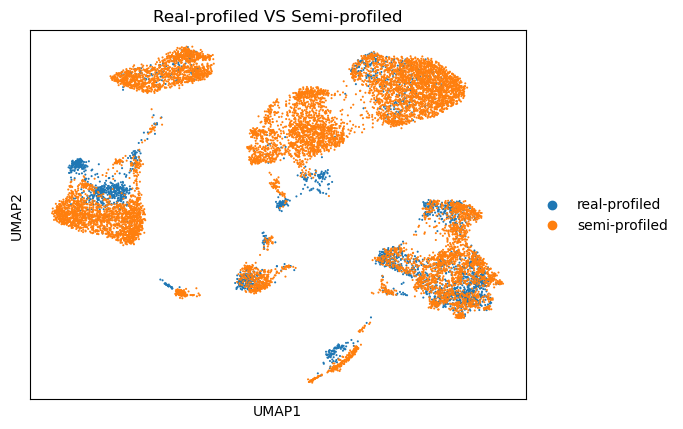

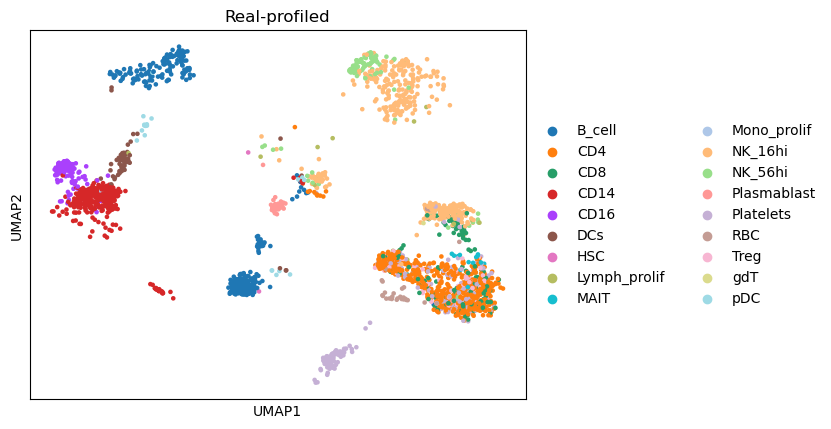

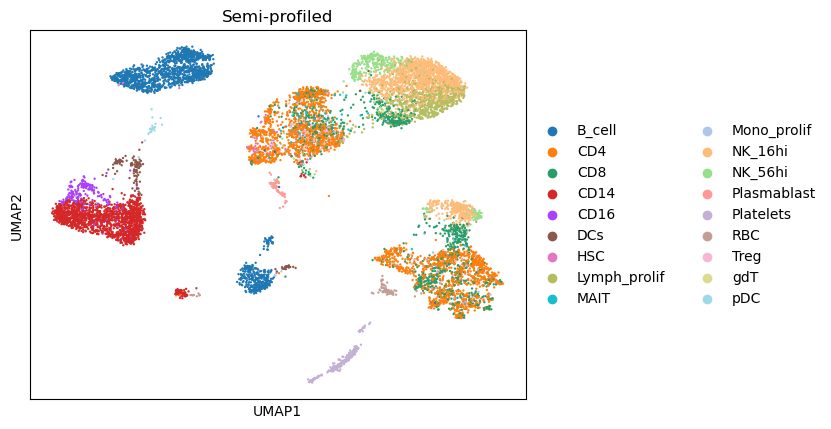

In [92]:
_ = compare_adata_umaps(
    inferred_rep,
    real_rep,                
    name = name,
    celltype_key = 'celltypes'
    )

In [91]:
totaltypes = np.array(inferred_rep.obs['celltypes'].cat.categories)
real_prop = celltype_proportion(real_rep,totaltypes)
inferred_prop = celltype_proportion(inferred_rep,totaltypes)
print('Pearson Correlation between the two versions of cell type proportions:')
print(scipy.stats.pearsonr(real_prop,inferred_prop))

Pearson Correlation between the two versions of cell type proportions:
PearsonRResult(statistic=0.9188102942534281, pvalue=7.341435677365842e-08)


A Pearson Correlation of 0.918 is generally considered as good deconvolution performance. So if your are mainly focusing on cell type-level analysis then you can stop here. If you are not satisfied with it or not satisfied with more in-depth analysis results, you can select more representatives and go to the next round.

## new representative selection using active learning

In [86]:
activeselect.activeselection(name, representatives,cluster,batch=2,lambdasc=1,lambdapb=1)

Running active learning to select new representatives
selection finished


## Round 3 semi-profiling

In [69]:
get_eg_representatives.get_eg_representatives(name)
scprocess.scprocess(name=name,singlecell=name+'/representative_sc.h5ad',normed='yes',cellfilter='no',threshold=1e-3,geneset='yes',weight='yes',k=15)

In [70]:
representatives = name + '/status/eer_representatives_3.txt'
cluster = name + '/status/eer_cluster_labels_3.txt'
scinfer(name, representatives,cluster,None,bulktype,device = 'cuda:0')

Start single-cell inference in cohort mode
pretrain 1: representative reconstruction
load existing pretrain 1 reconstruction model for BGCV09_CV0279
INFO     Generating sequential column names                                                                        
load existing pretrain 1 reconstruction model for MH9143426
INFO     Generating sequential column names                                                                        
load existing pretrain 1 reconstruction model for BGCV07_CV0137
INFO     Generating sequential column names                                                                        
load existing pretrain 1 reconstruction model for MH8919226
INFO     Generating sequential column names                                                                        
load existing pretrain 1 reconstruction model for BGCV03_CV0084
INFO     Generating sequential column names                                                                        
load existing pretrain 

In [71]:
activeselect.activeselection(name, representatives,cluster,batch=2,lambdasc=1,lambdapb=1)

Running active learning to select new representatives
selection finished


## Round 4 semi-profiling

In [ ]:
get_eg_representatives.get_eg_representatives(name)
scprocess.scprocess(name=name,singlecell=name+'/representative_sc.h5ad',normed='yes',cellfilter='no',threshold=1e-3,geneset='yes',weight='yes',k=15)
representatives = name + '/status/eer_representatives_4.txt'
cluster = name + '/status/eer_cluster_labels_4.txt'
scinfer(name, representatives,cluster,None,bulktype,device = 'cuda:0')

In [ ]:
activeselect.activeselection(name, representatives,cluster,batch=2,lambdasc=1,lambdapb=1)

## Round 5 semi-profiling

In [ ]:
get_eg_representatives.get_eg_representatives(name)
scprocess.scprocess(name=name,singlecell=name+'/representative_sc.h5ad',normed='yes',cellfilter='no',threshold=1e-3,geneset='yes',weight='yes',k=15)
representatives = name + '/status/eer_representatives_4.txt'
cluster = name + '/status/eer_cluster_labels_4.txt'
scinfer(name, representatives,cluster,None,bulktype,device = 'cuda:0')
activeselect.activeselection(name, representatives,cluster,batch=2,lambdasc=1,lambdapb=1)

## Error curve
After performing several rounds of semi-profiling, we can visualize how error and cost changes according to number of representatives selected.


### compute errors of each round

In [73]:
upperbounds, lowerbounds, semierrors, naiveerrors = get_error(name)

loading and processing ground truth data.
finished processing ground truth 1.0975678540125955  seconds
computing error for each round
round  1
loading semi-profiled cohort
1.1435612910136115 for loading semi-profiled cohort.
pca
14.882639236020623 for pca
computing errors
115.93720722399303 for computing error.
round  2
loading semi-profiled cohort
0.7599061620130669 for loading semi-profiled cohort.
pca
12.819295780995162 for pca
computing errors
94.123567756993 for computing error.
round  3
loading semi-profiled cohort
0.5450615989975631 for loading semi-profiled cohort.
pca
12.641344184987247 for pca
computing errors
80.74742992100073 for computing error.
round  4
loading semi-profiled cohort
0.311131131980801 for loading semi-profiled cohort.
pca
11.860231598024257 for pca
computing errors
76.9444539110118 for computing error.
round  5
loading semi-profiled cohort
0.23003774901735596 for loading semi-profiled cohort.
pca
12.683812806993956 for pca
computing errors
73.49961497602635

### visualize the errors

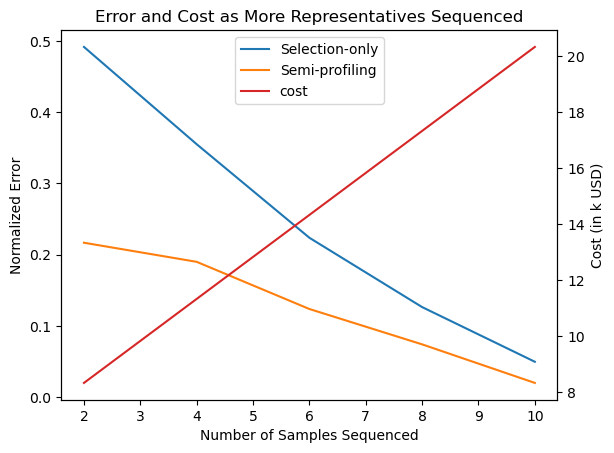

In [80]:
errorcurve(upperbounds, lowerbounds, semierrors, naiveerrors, batch=2,total_samples = 12)